In [1]:
import iris
from scipy.spatial import KDTree
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import iris.coord_categorisation
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
import pandas as pd
import datetime

/Users/ph290/miniconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
def extract_region(cube,lon_west,lon_east,lat_south,lat_north):
    cube_region_tmp = cube.intersection(longitude=(lon_west, lon_east))
    cube_region = cube_region_tmp.intersection(latitude=(lat_south, lat_north))
    return cube_region


def area_avg(cube):
    try:
        cube.coord('latitude').guess_bounds()
    except:
        pass
    try:
        cube.coord('longitude').guess_bounds()
    except:
        pass
    grid_areas = iris.analysis.cartography.area_weights(cube)
    return cube.collapsed(['longitude', 'latitude'], iris.analysis.MEAN, weights=grid_areas)

def extract_lat_lon(cube,my_lat,my_lon):
    lat = cube.coord('latitude')
    lon = cube.coord('longitude')
    lat_coord1 = lat.nearest_neighbour_index(my_lat)
    lon_coord1 = lon.nearest_neighbour_index(my_lon)
    return cube.data[:,lat_coord1,lon_coord1].data

In [3]:
file = '/Users/ph290/Downloads/era5_GBR/era5_GBR_surfacetemperature.nc'
# file_bottom = '/Users/ph290/Downloads/era5_GBR/era5_GBR_bottomtemperature_all_ym.nc'

# cube = iris.load_cube(file)[0]

cube_all = iris.load_cube(file)
try:
    iris.coord_categorisation.add_year(cube_all, 'time', name='year')
    iris.coord_categorisation.add_month(cube_all, 'time', name='month')
except:
    pass

# cube_all = cube_all.aggregated_by('year', iris.analysis.MEAN)


# cube_all.coord('longitude').points = cube_all.coord('longitude').points+180
# cube_all.data = np.ma.masked_array(cube_all.data)
# cube_all.data.fill_value = 9.96920997e+36
cube_all.data = np.ma.masked_where(cube_all.data == 9.96920997e+36, cube_all.data)
# iris.coord_categorisation.add_year(cube_all, 'time', name='year')

# the below allows us to query the nearest model pooint to the obs which is not masked
a = cube_all[0,:,:].data.copy()
a = np.ma.masked_where(np.logical_not(np.isfinite(a)),a)
# x,y=np.mgrid[0:a.shape[0],0:a.shape[1]]
x,y=np.meshgrid(cube_all.coord('longitude').points,cube_all.coord('latitude').points)
xygood = np.array((x[~a.mask],y[~a.mask])).T
# xybad = np.array((x[a.mask],y[a.mask])).T

/Users/ph290/miniconda2/lib/python2.7/site-packages/iris/fileformats/cf.py:1143: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)


In [144]:
# obs_file = 'NRSNSI.csv.gz'
# obs_file = 'GBRLSH.csv.gz'
# obs_file = 'GBRPPS.csv.gz'
# obs_file = 'NRSYON.csv.gz'
# obs_file = 'GBRHIS.csv.gz'
df = pd.read_csv('data/'+obs_file, compression='gzip',header=21)


obs_file = 'IMOS_FAIMMS.csv.gz'
df = pd.read_csv('data/'+obs_file, compression='gzip',header=39)



In [270]:
site_codes = np.unique(df.site_code)
# 7,8,12,13,14,16,17,18,21,22,23,24
site_code = site_codes[24]
df_surf = df.loc[(df.site_code == site_code) & (df.VALUES_quality_control == 1)]
lat = df_surf.LATITUDE.mean()
lon = df_surf.LONGITUDE.mean()

In [271]:


# min_lon = np.min(cube_all.coord('longitude').points)
# max_lon = np.max(cube_all.coord('longitude').points)
# min_lat = np.min(cube_all.coord('latitude').points)
# max_lat = np.max(cube_all.coord('latitude').points)

# if (lon >= min_lon) & (lon <= max_lon) & (lat >= min_lat) & (lat <= max_lat):
#     fig= plt.subplots(figsize=(10, 10))
#     #plot map of the mooring location
#     qplt.pcolormesh(cube_all[0])
#     plt.scatter(lon,lat)
#     plt.show()



/Users/ph290/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/ph290/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/ph290/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

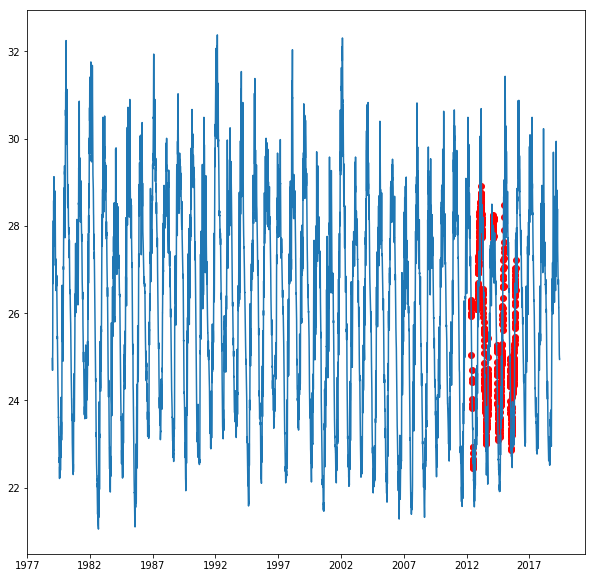

In [272]:
fig= plt.subplots(figsize=(10, 10))

index = KDTree(xygood).query([lon,lat])[1]
xygood[index][0]
model_ts = extract_lat_lon(cube_all,xygood[index][1],xygood[index][0])
time = cube_all.coord('time')
times = time.units.num2date(time.points)
where_good_data = np.where(model_ts < 1000.0)

    
if (lon >= min_lon) & (lon <= max_lon) & (lat >= min_lat) & (lat <= max_lat):
    plt.plot(times[where_good_data],model_ts[where_good_data])
    try:
#         df_surf['old_TIME'] = df_surf.TIME
        df_surf['TIME_datetime'] = pd.to_datetime(df_surf.TIME,format='%Y-%m-%dT%H:%M:%SZ')
        df_surf['year'] = df_surf.TIME_datetime.dt.year
        df_surf['month'] = df_surf.TIME_datetime.dt.month
        df_surf['day'] = df_surf.TIME_datetime.dt.day
        df_surf = df_surf.set_index('TIME_datetime',drop=False)
    except:
        pass

    df_surf = df_surf.groupby(pd.Grouper(freq='1D')).mean()
    plt.scatter(df_surf.index.values,df_surf.VALUES.values,color='r')
#     plt.ylim([15,30])
#     plt.xlim([datetime.date(2015, 1, 1), datetime.date(2020, 1, 1)])
    plt.show()


#     #extract model timeseries from cloases model data point
#     index = KDTree(xygood).query([lon,lat])[1]
#     xygood[index][0]
#     model_ts = extract_lat_lon(cube_all,xygood[index][1],xygood[index][0])
#     time = cube_all.coord('time')
#     times = time.units.num2date(time.points)
#     where_good_data = np.where(model_ts < 1000.0)
#     plt.plot(times[where_good_data],model_ts[where_good_data])
#     df_surf['TIME_datetime'] =  pd.to_datetime(df_surf.TIME)
#     plt.scatter(df_surf.TIME_datetime.values,df_surf.TEMP.values,color='r')
#     plt.ylim([15,30])
#     plt.show()

In [210]:
df[['site_code','VALUES']]
print site_codes

['DAVSF1' 'HIRP1' 'HIRP2' 'HIRP3' 'HIRP5' 'HIRP6' 'HIRP7' 'HIRP8' 'HISF1'
 'HISF2' 'HISF3' 'HISF4' 'LIZRP2' 'LIZSF1' 'LIZSF2' 'LIZSF3' 'MRYSF1'
 'OIRP1' 'OIRP2' 'OIRP3' 'OISF2' 'OTIRP1' 'OTIRP2' 'OTIRP3' 'RIBSF1']


In [109]:
df_surf

,timeseries_id,index,instrument_nominal_depth,TIME_quality_control,LATITUDE,LATITUDE_quality_control,LONGITUDE,LONGITUDE_quality_control,DEPTH,DEPTH_quality_control,...,PRES_REL_quality_control,depth_b,sea_water_temperature_b,sea_water_electrical_conductivity_b,sea_water_salinity_b,sea_water_pressure_b,sea_water_pressure_due_to_sea_water_b,year,month,day
TIME_datetime,,,,,,,,,,,,,,,,,,,,,
2013-05-29,20868.730769,9.000000,7.307692,NaN,-14.7041,NaN,145.6268,NaN,1.014485,4.000000,...,NaN,1.0,1.0,0.0,0.0,0.0,0.0,2013.0,5.0,29.0
2013-05-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-06-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-06-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-06-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-06-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-06-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
df_surf['TIME_datetime'] = pd.to_datetime(df_surf.TIME,format='%Y-%m-%dT%H:%M:%SZ')
df_surf.TIME_datetime.dt.year
df_surf.TIME_datetime.dt.month
df_surf.TIME_datetime.dt.day

/Users/ph290/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0          29
1          29
2          29
501060     11
501061     11
501062     11
501063     11
501064     11
501065     11
501066     11
501067     11
501068     11
501069     11
501070     11
501071     11
501072     11
501073     11
501074     11
501075     11
501076     11
501077     11
501078     11
501079     11
501080     11
501081     11
501082     11
501083     11
501084     11
501085     11
501086     11
           ..
1530985    12
1530986    12
1530987    12
1530988    12
1530989    12
1530990    12
1530991    12
1530992    12
1530993    12
1530994    12
1530995    12
1530996    12
1530997    12
1530998    12
1530999    12
1531000    12
1531001    12
1531002    12
1531003    12
1531004    12
1531005    12
1531006    12
1531007    12
1531008    12
1531009    12
1531010    12
1531011    12
1531012    12
1531013    12
1531014    12
Name: TIME_datetime, Length: 1968, dtype: int64

In [119]:
df[['TIME','TEMP']].iloc[1500:1600]

,TIME,TEMP
1500,2013-05-30T01:00:00Z,25.94
1501,2013-05-30T01:01:00Z,25.94
1502,2013-05-30T01:02:00Z,25.94
1503,2013-05-30T01:03:00Z,25.95
1504,2013-05-30T01:04:00Z,25.94
1505,2013-05-30T01:05:00Z,25.94
1506,2013-05-30T01:06:00Z,25.94
1507,2013-05-30T01:07:00Z,25.94
1508,2013-05-30T01:08:00Z,25.94
1509,2013-05-30T01:09:00Z,25.95


In [126]:
df_surf.year

TIME_datetime
2013-05-29 00:00:00    2013
2013-05-29 00:01:00    2013
2013-05-29 00:02:00    2013
2014-05-11 23:00:00    2014
2014-05-11 23:01:00    2014
2014-05-11 23:02:00    2014
2014-05-11 23:03:00    2014
2014-05-11 23:04:00    2014
2014-05-11 23:05:00    2014
2014-05-11 23:06:00    2014
2014-05-11 23:07:00    2014
2014-05-11 23:08:00    2014
2014-05-11 23:09:00    2014
2014-05-11 23:10:00    2014
2014-05-11 23:11:00    2014
2014-05-11 23:12:00    2014
2014-05-11 23:13:00    2014
2014-05-11 23:14:00    2014
2014-05-11 23:15:00    2014
2014-05-11 23:16:00    2014
2014-05-11 23:17:00    2014
2014-05-11 23:18:00    2014
2014-05-11 23:19:00    2014
2014-05-11 23:20:00    2014
2014-05-11 23:21:00    2014
2014-05-11 23:22:00    2014
2014-05-11 23:23:00    2014
2014-05-11 23:24:00    2014
2014-05-11 23:25:00    2014
2014-05-11 23:26:00    2014
                       ... 
2014-05-12 14:31:00    2014
2014-05-12 14:32:00    2014
2014-05-12 14:33:00    2014
2014-05-12 14:34:00    2014
2014-0

In [128]:
df['TIME_datetime'] = pd.to_datetime(df.TIME,format='%Y-%m-%dT%H:%M:%SZ')
df['year'] = df.TIME_datetime.dt.year
df['month'] = df.TIME_datetime.dt.month
df['day'] = df.TIME_datetime.dt.day

In [143]:
df[df.DEPTH < 40][['TIME','TEMP','DEPTH']]


,TIME,TEMP,DEPTH
0,2013-05-29T00:00:00Z,26.12,1.2527
1,2013-05-29T00:01:00Z,26.04,1.3662
2,2013-05-29T00:02:00Z,25.98,1.7523
3,2013-05-29T00:03:00Z,25.94,2.1384
4,2013-05-29T00:04:00Z,25.91,2.5245
5,2013-05-29T00:05:00Z,25.89,2.9107
6,2013-05-29T00:06:00Z,25.87,3.2968
7,2013-05-29T00:07:00Z,25.86,3.6829
8,2013-05-29T00:08:00Z,25.86,4.0690
9,2013-05-29T00:09:00Z,25.85,4.4551
